# LLM Introduction

Language models

Probabilistic formulation

Large Language models




## Language models probabilistic formulation

Language models are trained from discrete tokens. For ease of understanding equate roughly a token to a word. Say we have a super set of tokens $T = \{t_1, t_2,\dots,t_n\}$ from which we create training dataset to train a language model. Remember, order of these tokens is important. Token $t_2$ is preceded by $t_1$ and succeded by $t_3$. Given a bunch of tokens, predicting the next most probable token is the objective of our language model.Here is a sample single training record pair passed to train the model.

$$
x_1=\{t_1, t_2, t_3, t_4 \}\quad
y_1=\{t_2, t_3, t_4, t_5 \}
$$

The labels are created from x by sliding one step to the right. Input length,number of tokens,is predefined and called as context length in language model literature. Modle llama-2 has a context length of 4K; each instance of its training record had 4K tokens. The output y values can be derived automatically from the input x. This makes creating a dataset for a language model much easier. We dont need separate time and resource to create a labelled dataset.

Hard to follow these notation? here is a python snippet showing token superset and training samples using words.



In [83]:

text = "Large language models are deep neural network trained on vast amount of text data."
T = [x for x in text.split(" ")]

print(f"Tokens superset \n {T}")


X = []
y = []

k=3
for i in range(len(T)-k):
    X.append(T[i:i+k])
    y.append(T[i+1:i+k+1])

print(f"Training Instances")

for x,y in zip(X,y):
    print(f"X: {x} y: {y}")

Tokens superset 
 ['Large', 'language', 'models', 'are', 'deep', 'neural', 'network', 'trained', 'on', 'vast', 'amount', 'of', 'text', 'data.']
Training Instances
X: ['Large', 'language', 'models'] y: ['language', 'models', 'are']
X: ['language', 'models', 'are'] y: ['models', 'are', 'deep']
X: ['models', 'are', 'deep'] y: ['are', 'deep', 'neural']
X: ['are', 'deep', 'neural'] y: ['deep', 'neural', 'network']
X: ['deep', 'neural', 'network'] y: ['neural', 'network', 'trained']
X: ['neural', 'network', 'trained'] y: ['network', 'trained', 'on']
X: ['network', 'trained', 'on'] y: ['trained', 'on', 'vast']
X: ['trained', 'on', 'vast'] y: ['on', 'vast', 'amount']
X: ['on', 'vast', 'amount'] y: ['vast', 'amount', 'of']
X: ['vast', 'amount', 'of'] y: ['amount', 'of', 'text']
X: ['amount', 'of', 'text'] y: ['of', 'text', 'data.']



While we train the model, it learns to predict $t_5$ given ${t_1,t_2,t_3,t_4}$. To simply put it we are training the model to do next word prediction. These are called as *autoregressive models* or *causal models*. 
For ease of demonstration let us work on a tiny super set consisting of 4 tokens, ${t_1,t_2,t_3,t_4}$. We create our training data pair as follows,

$$
x_1 = \{t_1, t_2 \}\quad
y_1 = \{t_2, t_3 \}
$$
$$
x_2 = \{t_2, t_3 \}\quad
y_2 = \{t_3, t_4 \}
$$
$$
x_3 = \{t_3, t_4 \}\quad
y_3 = \{t_4, EOS \}
$$

<EOS> is a special token indicating the end of the stream.Say we train the model using above training data.Based on the training pair $<x_1,y_1>$ we expect the model to assign high probability for $t_3$ when $\{t_1, t_2 \}$ is fed as model input. We want maximum probabilities for 
 
$$
P(t_3|t_2,t_1)\quad P(t_4|t_3,t_2)\quad P(EOS|t_4,t_3)\quad
$$
    
and a probability as close as to zero for the following input ouput combinations.

$$
P(t_2|t_2,t_1)\quad P(t_4|t_2,t_1)\quad P(EOS|t_2,t_1)\quad P(t_1|t_2,t_1)
$$
$$
P(t_3|t_3,t_2)\quad P(t_3|t_3,t_2)\quad P(t_1|t_3,t_2)\quad P(EOS|t_3,t_2)
$$
$$
P(t_2|t_2,t_1)\quad P(t_4|t_2,t_1)\quad P(EOS|t_2,t_1)\quad P(t_1|t_2,t_1)
$$


If we get the following scenario from a model,
$$
P(t_3 | t_2,t_1) < P(t_4 | t_2,t_1)
$$

After training if our model thinks, $t_3$ is the correct token for input $<t_1,t_2>$, we know our model is not trained properly. Since each training pair is independent of the other, we can multiply their probabilities to get the overall probability of our training data.

$$
P(t_1,t_2,t_3,EOS;\theta)=P(t_3|t_2,t_1)\cdot P(t_4|t_3,t_2)\cdot P(EOS|t_4,t_3)
$$
    
This is our objective function or better our likelihood function. Let us call all the parameters of the language model we intend to train as $\theta$. Our objective is to find the best parameters $\theta$ so that *likelihood* of this model predicting the correct next token, given a series of input tokens is very high. Remember these are probabilistic models. So the likelihood of a language model for given training example $(x_i, y_i)$ is the probability the model assings to the correct $y_i$. We can hence say our objective is to find a model with parameters $\theta$ which can achieve maximum likelihood for the given training data. 

All these probabilities are very small values. Mutliplying them will further reduce these values and may lead to numerical stability issues due to the limited precision of floating point numbers. For float32 datatype the smallest number is close to $10^-45$. We can address this issue through scaling, we convert all our probability values to log scale.

$$
log(P(t_1,t_2,t_3, \theta)) = log(P(t_3 | t_2,t_1)) + log(P(t_4|t_3,t_2)) + log(P(EOS|t_4,t_3))
$$

The above equation is log of our likelihood equation and hence called as loglikelihood.
The below python snippet explains how we can move to log scale and still face no impediments in that process. The log functions are stricly monotonic in nature and hence they help us to scale down of our values and successfully address numerical instability issues.

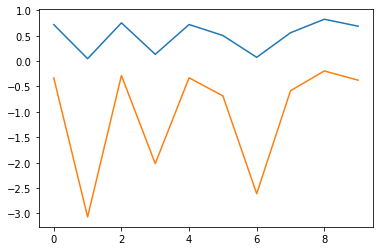

In [84]:
import matplotlib.pyplot as plt
import numpy as np

fx = lambda x: np.sin(x)
lfx = lambda x: np.log(np.sin(x))

x = np.random.random(10)


plt.plot(fx(x))
plt.plot(lfx(x))

Logarithms are *stricly monatonic*. They change the values, but not does not changes the shape, you see that peaks and valleys are same for both the functions in the above example. fx and lfx are two functions, where the second is a log of values thrown by the first function. Coming back to our loglikelihood equation, we can write it in a generic way.

For super set of tokens $T = \{t_1, t_2,...t_n\}$, say context length is k, we can write above equation as

$
log(P(X,\theta)) = \sum_{i=1}^n log(P(t_i+k|t_i-k,..t_i+1,t_i))
$

As said earlier our objective is to build a model, which has the right parameters $\theta$, such that the output probabilities of correct output token is maximized. In other words, we want our $\theta$ such that value of the above equation is at the highest. To further iron it out, say we have two models, the first model has parameters $\theta_1$ and the second model has parameters $\theta_2$ if

$
log(P(X,\theta_1)) >> log(P(X,\theta_2))
$

we can conclude that our second model is superior to our first model. We know what needs to be done to build a language model. Find a model with $/theta$ parameters which will maximize our log-likelihood function. Let us now see how do we go about building such a model.

In a machine learning framework, the model parameters $\theta$ are learned in an iterative manner. Start with (not so) random initialization of the parameters. Use these parameters to get the outputs. Compare the actual output with the expected output. Adjust your parameters based on this comparision. With the updated parameters calculate the output, compare the output with expected output. Repeat this cycle for a number of times till you are satisfied that your model output is close enough to expected output. The comparision part is called as the loss function. The ML framework is designed to minimize this loss function. 

The figure below shows the a sample input and corresponding output produced by the model.

```{figure} ../images/llm_io.jpg
---
height: 150px
name: llm-io-fig
---
Input and output to a language model
```

For illustration we have assumed context length as two. So for token 1 and token 2, the model predicts a distribution over all the tokens in the superset. For token 1, you can see that we have logits values for all the tokens $t_1$ to $t_5$. These values dont sum up to one, they can be passed to a softmax normalization later to be normalized. We expect that when the model is trained, for token $t_1$, the model should assign high logit value to $t_2$ and similarly for $t_2$ high logit values for $t_3$.

The first row of the output has the following likelihood values,

$$
P(t_1 | t_1), P(t_2 | t_1), P(t_3 | t_1), P(t_4 | t_1), P(t_5 | t_1) 
$$

A note; though we use P() these are not probability values. They are logit values. We will get the probability values after normalizing it through a softmax function.

However we are interested only in $P(t_2 | t_1)$. During the course of our training we want this value to go up. We specifically want to inform the model to increase this value during the course of training. Say we use a one-hot encoded vector $[0,1,0,0,0]$ and multiply with the above vector, we will only include the value of $t_2$ and ignore the rest. Similary for $t_3$ we can use the encoded vector $[0,1,0,0,0]$.

Here is a python snipped to explain this.



In [85]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

y_true = np.asarray([
           [0.,1.,0.,0.,0.]
          ,[0.,0.,1.,0.,0.]
         ])
logits = np.asarray([
          [0.02,0.896,0.344,0.4567,0.76]
         ,[.23,.002,.789,.654,.567]
         ])

probability     = softmax(logits)
log_probability = np.log(probability)

log_prob_training_instance = np.sum(y_true * log_probability)
log_prob_training_instance

-3.951280674629951

In the python code, we got the probability values by normalizing the logits using softmax function and then took the log of those probability values. Finally using our one hot encoded matrix of our target values, to get the log probability assigned by the model.We need to maximize this value. Let us write this calculation in mathematical format.

$$
log(P(x_j, \theta)) = \sum_{j} p_j^{True}.log(p_j)
$$

Say if we have n baches of training data, log probability will be the average of all the batches.
$$
log(P(X, \theta)) = \sum_{i=1}^n p_i^{True}.log(p_i)
$$

ML Frameworks are setup to minimize a function. Hence instead of maximizing log(P(X)), we will minimize negative of log(P(X)). Our likelihood is hence called as negative log likelihood.

$$
NLL = -\frac{1}{n}.\sum_{i=1}^n p_i^{True}.log(p_i)
$$


Having arrived at the objective function and a loss function, the typical machine learning loop for training is the model is as follows,

1. Initialize the model parameters $\theta$
2. Ingest a batch of input into the model and produce the output
3. Calculate the loss using the NLL function
4. Derive the gradients of model parameters w.r.t loss
5. update the parameters using the gradients.
6. Return to step 2 and proceed for n times or till some condition is met.

## Ollama

Ollama enables us to run open source LLMs locally. A tool that enables local deployment of large language models. A great tool for experimetning with LLMs. No need cloud hosting.
http://github.com/ollama/ollama. Refer to the website for installation.

Advantages for using Ollama,

1. Quick iteratvie development without needing to deploy model changes
2. Privacy and security - data does not leave your machine.
3. cost - more cost effective than making API calls.
4. control - more control over the model

Let us proceed to install ollama.

 curl  -fsSL https://ollama.com/install.sh | sh


    >>> Installing ollama to /usr/local/bin...
    >>> Creating ollama user...
    ........
    >>> NVIDIA GPU installed.

    sudo systemctl status ollama
    ● ollama.service - Ollama Service
         Loaded: loaded (/etc/systemd/system/ollama.service; enabled; vendor preset: enabled)
         Active: active (running) since Sat 2024-05-11 19:59:42 EDT; 5min ago
       Main PID: 1053781 (ollama)
          Tasks: 18 (limit: 18827)
         Memory: 480.5M
         CGroup: /system.slice/ollama.service
                 └─1053781 /usr/local/bin/ollama serve
    
    May 11 19:59:42 gopi-G5-MD ollama[1053781]: Couldn't find '/usr/share/ollama/.ollama/id_ed25519'. Generating new private key.
    May 11 19:59:42 gopi-G5-MD ollama[1053781]: Your new public key is:
    May 11 19:59:42 gopi-G5-MD ollama[1053781]: ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIPkwrlZDwOjnkF2xAiAWVxs8CrIfsqSnNcs3adQQv9xC
    May 11 19:59:42 gopi-G5-MD ollama[1053781]: 2024/05/11 19:59:42 routes.go:1006: INFO server config env="map[OLLAMA_DEBUG:false OLLAMA_LLM_LIBRARY: OLLAMA_MAX_LOADED_MODELS:1 OLLAMA_MAX_QUEUE:512 OLLAMA_>
    lines 1-19/19 (END)




### Pull a model

Using the pull command through ollama cli, we can pull models of interest. Here we are going to pull phi3 model from microsoft.

`ollama pull phi3`


### List of available models

Through list command, we can look at all the models available locally through ollama.

    (base) gopi@gopi-G5-MD:~/Documents/small_llm$ ollama list
    NAME       	ID          	SIZE  	MODIFIED       
    phi3:latest	a2c89ceaed85	2.3 GB	19 seconds ago	


Now listing the model shows phi3 model. The models are stored as blob in /usr/share/ollama/.ollama

Ollama bundles the model into a single package defined by a Modelfile. 

### Interacting with LLM

    `ollama run phi3:latest`
    
The above command should open the terminal to interact with phi3.
    
    >>> Why is the sky blue in color?
     The sky appears blue to our eyes because of a phenomenon called Rayleigh scattering. As sunlight travels through Earth's atmosphere, it encounters molecules and small particles that are much 
    smaller than its wavelength. These particles scatter shorter-wavelength light (blue and violet) more effectively than longer-wavelength light (red, orange).
    
    However, our eyes are less sensitive to violet light, and the Sun emits less violet light compared to blue light; that's why we see a predominantly blue sky during daytime. At sunrise or sunset, 
    when the light path through the atmosphere is longer, even more scattering of red and orange wavelengths occurs, which makes the sky appear in shades of red, pink, and orange.
    
    The overall color perception can also be affected by atmospheric conditions such as pollution or dust particles. But under normal circumstances on a clear day, Rayleigh scattering is responsible 
    for the blue coloration of our sky.
    
    >>> Send a message (/? for help)



### Ollama's REST API

In [8]:
import urllib.request
import json

url   = "http://localhost:11434/api/chat"
model = "phi3:latest"

prompt = "Tell me three reasons why the sky is blue."
data = {
    "model": model
   ,"messages": [
       {
           "role":"user"
          ,"content": prompt 
       }
   ]
  ,"options":{
      "seed": 77
     ,"temperature": 0.9 
  }  
}    

payload = json.dumps(data).encode("utf-8")
payload

b'{"model": "phi3:latest", "messages": [{"role": "user", "content": "Tell me three reasons why the sky is blue."}], "options": {"seed": 77, "temperature": 0.9}}'

In [10]:
request = urllib.request.Request(url,data=payload,method="POST")
request.add_header("Content-Type","application/json")

response_data=""

with urllib.request.urlopen(request) as response:
    while True:
        line = response.readline().decode("utf-8")
        if not line:
            break
        response_json = json.loads(line)
        response_data+= response_json["message"]["content"]

print(response_data)

        

1. Scattering: The color of the sky appears due to Rayleigh scattering, where molecules and small particles in the atmosphere are deflected or scattered shorter-wavelength blue light (like from the sun) more than longer wavelength red light when it interacts with them during daylight hours. As a result, we see this dispersed blue color across our sky most of the time.

2. Earth'in Shape: The fact that earth is spherical also contributes to why we perceive different colors in the sky at various times and places on earth due to varying angles between sunlight rays hitting us directly (sun up high) or from a lower angle after dawn, which increases Rayleigh scattering effects.

3. Oxygen: The gas composition of our atmosphere also contributes significantly as it has nitrogen, oxygen but very little molecular hydrogen and helium - all these contribute to different colors scattered by the sky depending on their interaction with light rays from sunlight at various angles during a day or night